# **Análise de vulnerabilidades por ferramentas de AppSec 👩‍💻**


#### Descricao do problema: analisar ferramentas de seguranca que detectam vulnerabilidades (SAST, DAST e SCA) em diversos projetos ao longo. Assim, sera analisado a quantidade de vulnerabilidades que cada uma trouxe, os tipos de vulnerabilidades e quantidade de vulnerabilidade encontrada nos projetos ao longo do tempo

#### Hipoteses: Qual ferramenta detecta mais vulnerabilidade? Qual vulnerabilidade mais ocorre nas aplicacoes? Qual app aumentou a quantidade de vulnerabilidade pelo tempo? Qual ferramenta demora mais para corrigir as vulnerabilidades?

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# importacao de pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import missingno as ms # para tratamento de missings
import plotly.express as px #biblioteca para graficos com visual mais atraente

from io import BytesIO
import requests as rq


In [2]:
!pip install openpyxl

## Carga de Dataset

In [3]:
# informa o arquivo XLSX de importacao para o dataset
# file_xlsx = 'appsec_sample.xlsx'
file_xlsx = 'https://raw.githubusercontent.com/michelleamesquita/puc-mvp-2/main/appsec_sample.csv'

# lê o arquivo na pasta raiz do projeto

dataset = pd.read_csv(file_xlsx, delimiter=';', skiprows=0, low_memory=False)

# exibindo as primeiras linhas
dataset.head()

critical_vuln  high_vuln  medium_vuln  dt_created  \
0            0.0         62           97  01/12/2022   
1            0.0          6            2  14/11/2022   
2            NaN          0            1  16/05/2023   
3            NaN          6           15  15/05/2023   
4            NaN        147          216  15/05/2023   

                                         issues_list  tool cd_month_start  \
0  ['CVE-2020-11988', 'Cxb3498186-093f', 'CVE-202...   SCA     01/12/2022   
1  ['CVE-2022-3517', 'CVE-2022-23647', 'CVE-2022-...   SCA     01/11/2022   
2  ['Client Privacy Violation', 'Client HTML5 Sto...  SAST     01/05/2023   
3  ['Reflected XSS All Clients', 'Stored XSS', 'C...  SAST     01/05/2023   
4  ['Reflected XSS All Clients', 'Stored XSS', 'C...  SAST     01/05/2023   

   id_vulnerability   scan_date  
0                 0  15/06/2023  
1                 1  15/06/2023  
2                 2  15/06/2023  
3                 3  15/06/2023  
4                 4  15/06/2023

#### Os dados sao do tipo de modelo supervisionado. Podemos ver que conhecemos a entrada dos dados que são rotulados. Sabemos as características dele.
---
#### `critical_vuln` => quantidade de vulnerabilidades criticas
#### `high_vuln `=> quantidade de vulnerabilidades altas
#### `medium_vuln` => quantidade de vulnerabilidades medias
#### `dt_created` => vulnerabilidades detectadas nas ferramentas
#### `issues_list` =>  lista de vulnerabilidades detectadas nas ferramentas
#### `tool` => ferramenta utilizada para detectar vulnerabilidade
#### `cd_month_start` => mes que detectou vulnerabilidade
#### `id_vulnerability` => aplicacoes com vulnerabilidade identificadas por id
#### `scan_date` => scan realizado para coletar informacao das vulnerabilidades

### Tratamento de Missings

In [4]:
# verificando nulls no dataset
dataset.isnull().sum()

critical_vuln       675
high_vuln             0
medium_vuln           0
dt_created            0
issues_list           0
tool                  0
cd_month_start        0
id_vulnerability      0
scan_date             0
dtype: int64

#### É possível ver que na coluna `critical_vuln` possui vários NaN

<Axes: >

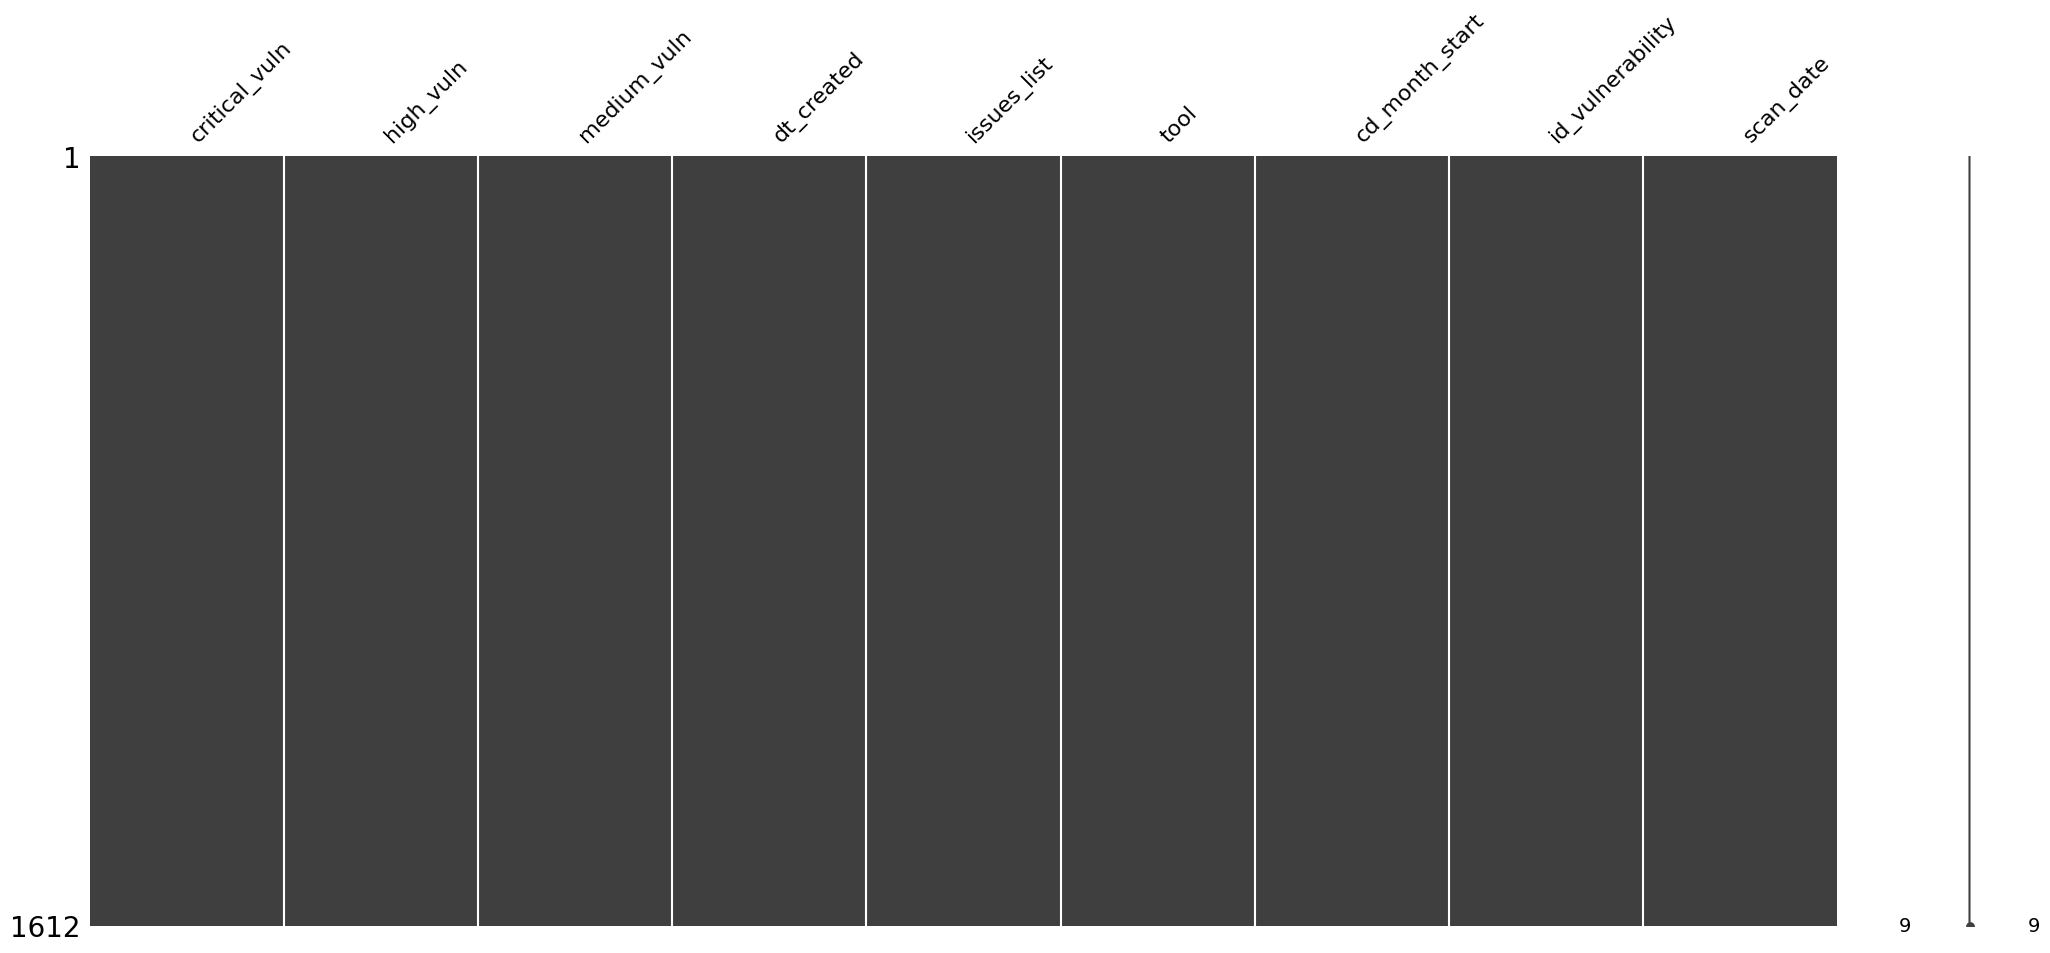

In [5]:
# salvando um novo dataset para tratamento de missings

# recuperando os nomes das colunas
col = list(dataset.columns)

# o novo dataset irá conter todas as colunas do dataset original
datasetSemMissings = dataset[col[:]]

# substituindo os NaN por 0
datasetSemMissings.replace(np.nan,0, inplace=True)

# exibindo visualizacao matricial da nulidade do dataset
ms.matrix(datasetSemMissings)

#### No grafico acima, é possível ver que não há nenhum NaN (not a number) aparecendo, pois aonde existia esse valor, foi alterado por zero

In [6]:
# verificando novamente nulls no dataset
datasetSemMissings.isnull().sum()

critical_vuln       0
high_vuln           0
medium_vuln         0
dt_created          0
issues_list         0
tool                0
cd_month_start      0
id_vulnerability    0
scan_date           0
dtype: int64

###Análise exploratória

In [7]:
# mostra as informacoes do dataset
datasetSemMissings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612 entries, 0 to 1611
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   critical_vuln     1612 non-null   float64
 1   high_vuln         1612 non-null   int64  
 2   medium_vuln       1612 non-null   int64  
 3   dt_created        1612 non-null   object 
 4   issues_list       1612 non-null   object 
 5   tool              1612 non-null   object 
 6   cd_month_start    1612 non-null   object 
 7   id_vulnerability  1612 non-null   int64  
 8   scan_date         1612 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 113.5+ KB


In [8]:
# mostra as 5 últimas linhas do dataset
datasetSemMissings.tail(5)

critical_vuln  high_vuln  medium_vuln  dt_created  \
1607            0.0          0            1  14/10/2023   
1608            0.0          0            0  14/10/2023   
1609            0.0          0            4  18/10/2023   
1610            0.0          0            0  15/10/2023   
1611           10.0         10            9  15/10/2023   

                                            issues_list  tool cd_month_start  \
1607  ['CookieNotMarkedAsSecure,SameSiteCookieNotImp...  DAST     01/10/2023   
1608  ['MissingXFrameOptionsHeader,MissingXssProtect...  DAST     01/10/2023   
1609  ['RedirectBodyTooLarge,IisVersionDisclosure,As...  DAST     01/10/2023   
1610  ['MissingXFrameOptionsHeader,MissingXssProtect...  DAST     01/10/2023   
1611  ['AutoCompleteEnabled,AutoCompleteEnabledPassw...  DAST     01/10/2023   

      id_vulnerability   scan_date  
1607                99  23/10/2023  
1608               100  23/10/2023  
1609               101  23/10/2023  
1610               102  23/10/2023  
1611               103  23/10/2023

In [9]:
# faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis) e formata com 2 casas decimais
datasetSemMissings.describe().applymap(lambda x: f"{x:0.2f}").drop('id_vulnerability', axis=1)

critical_vuln high_vuln medium_vuln
count       1612.00   1612.00     1612.00
mean           0.10     22.32       42.76
std            0.99    132.86      233.84
min            0.00      0.00        0.00
25%            0.00      0.00        0.00
50%            0.00      1.00        5.00
75%            0.00     16.00       29.00
max           10.00   4488.00     8145.00

#### É possível ver que temos mais de 1000 dados coletados e que foi detectado mais vulnerabilidades do tipo média nas aplicacoes

##Quantidade de vulnerabilidade por ferramenta de segurança

In [10]:
# cria dataframe temporario para analisar qual ferramenta detecta mais vulnerabilidades

df=datasetSemMissings.groupby('tool').sum().apply(lambda x: x.sort_values(ascending=True)).drop('id_vulnerability', axis=1)

# cria soma das colunas
col_list= ['high_vuln', 'critical_vuln', 'medium_vuln']
df['total'] = df[col_list].sum(axis=1)
df.sort_values('total',ascending=False)

critical_vuln  high_vuln  medium_vuln    total
tool                                                
SAST            0.0      20928        45798  66726.0
SCA             0.0      14871        22595  37466.0
DAST          160.0        181          541    882.0


#### Na tabela acima, é possível ver que o SAST tem mais vulnerabilidade que as demais ferramentas. Isso ocorre porque a ferramenta SAST estar no início da pipeline do ciclo de desenvolvimento do software seguro (SSDLC)

### Cálculo para calcular quantidade de vulnerabilidades x mês é corrigida

In [11]:
# Criar coluna de data e ordenar por data e vuln

datasetSemMissings['Date'] = pd.to_datetime(datasetSemMissings['scan_date'])
datasetSemMissings['Month'] = datasetSemMissings['Date'].dt.month

datasetSemMissings = datasetSemMissings.sort_values(['id_vulnerability','Date'], ascending=False)


# criar lista com soma de vulnerabilidades
col_list= ['high_vuln', 'critical_vuln', 'medium_vuln']

# soma de vulnerabilidades
datasetSemMissings['total_vulns'] = datasetSemMissings[col_list].sum(axis=1)

# fazer a diferenca pelo id da vulnerabilidade e preencher com ultimo valor. se nao houver como fazer a diferença, utiliza o valor atual

datasetSemMissings['vulns_difference'] = (datasetSemMissings['total_vulns'].groupby(datasetSemMissings['id_vulnerability']).diff().fillna(datasetSemMissings['total_vulns']))


datasetSemMissings.head()

critical_vuln  high_vuln  medium_vuln  dt_created  \
955             0.0          2            5  22/07/2023   
954             0.0         26           16  07/07/2023   
953             0.0         15           13  04/08/2023   
952             0.0          4            0  08/08/2023   
1174            0.0          1            0  22/11/2022   

                                            issues_list tool cd_month_start  \
955   ['CVE-2022-25857', 'CVE-2022-38751', 'CVE-2022...  SCA     01/07/2023   
954   ['CVE-2021-23382', 'CVE-2021-23368', 'CVE-2022...  SCA     01/07/2023   
953   ['CVE-2023-20863', 'CVE-2016-1000027', 'CVE-20...  SCA     01/08/2023   
952   ['Cxf6e7f2c1-dc59', 'Cxdca8e59f-8bfe', 'Cx8bc4...  SCA     01/08/2023   
1174                                 ['CVE-2023-30533']  SCA     01/11/2022   

      id_vulnerability   scan_date       Date  Month  total_vulns  \
955                222  15/08/2023 2023-08-15      8          7.0   
954                221  15/08/2023 2023-08-15      8         42.0   
953                220  15/08/2023 2023-08-15      8         28.0   
952                219  15/08/2023 2023-08-15      8          4.0   
1174               219  05/09/2023 2023-05-09      5          1.0   

      vulns_difference  
955                7.0  
954               42.0  
953               28.0  
952                4.0  
1174              -3.0

## Tipos de vulnerabilidade encontradas

In [12]:
df_temp=datasetSemMissings
df_temp.issues_list=df_temp.issues_list.str.split()
df_vulns=df_temp.explode('issues_list')
df_vulns.issues_list=df_vulns.issues_list.str.replace("[","")
df_vulns.issues_list=df_vulns.issues_list.str.replace("]","")
df_vulns.head()


critical_vuln  high_vuln  medium_vuln  dt_created        issues_list  \
955            0.0          2            5  22/07/2023  'CVE-2022-25857',   
955            0.0          2            5  22/07/2023  'CVE-2022-38751',   
955            0.0          2            5  22/07/2023   'CVE-2022-1471',   
955            0.0          2            5  22/07/2023  'CVE-2022-41854',   
955            0.0          2            5  22/07/2023  'CVE-2022-38752',   

    tool cd_month_start  id_vulnerability   scan_date       Date  Month  \
955  SCA     01/07/2023               222  15/08/2023 2023-08-15      8   
955  SCA     01/07/2023               222  15/08/2023 2023-08-15      8   
955  SCA     01/07/2023               222  15/08/2023 2023-08-15      8   
955  SCA     01/07/2023               222  15/08/2023 2023-08-15      8   
955  SCA     01/07/2023               222  15/08/2023 2023-08-15      8   

     total_vulns  vulns_difference  
955          7.0               7.0  
955          7.0               7.0  
955          7.0               7.0  
955          7.0               7.0  
955          7.0               7.0

In [13]:
df_vulns.sort_values('total_vulns',ascending=False).head()

critical_vuln  high_vuln  medium_vuln  dt_created  issues_list  tool  \
15            0.0        109         8145  15/05/2023      'Client  SAST   
15            0.0        109         8145  15/05/2023    Hardcoded  SAST   
15            0.0        109         8145  15/05/2023   'Heuristic  SAST   
15            0.0        109         8145  15/05/2023          SQL  SAST   
15            0.0        109         8145  15/05/2023  Injection',  SAST   

   cd_month_start  id_vulnerability   scan_date       Date  Month  \
15     01/05/2023                15  15/06/2023 2023-06-15      6   
15     01/05/2023                15  15/06/2023 2023-06-15      6   
15     01/05/2023                15  15/06/2023 2023-06-15      6   
15     01/05/2023                15  15/06/2023 2023-06-15      6   
15     01/05/2023                15  15/06/2023 2023-06-15      6   

    total_vulns  vulns_difference  
15       8254.0            8033.0  
15       8254.0            8033.0  
15       8254.0            8033.0  
15       8254.0            8033.0  
15       8254.0            8033.0

## Top 20 vulnerabilidades encontradas

In [14]:
y = df_vulns.head(20).sort_values('total_vulns',ascending=False).total_vulns
fig = px.pie(df_vulns.head(20).sort_values('total_vulns',ascending=False), values=y, names='issues_list')
fig.show()

#### É possivel analisar que há 13 vulnerabilidades empatadas

### Top 20 vulnerabilides x ferramenta

In [15]:
y = df_vulns.head(20).sort_values('total_vulns',ascending=False).total_vulns
fig = px.bar(df_vulns.head(20).sort_values('total_vulns',ascending=False), x=df_vulns.head(20).sort_values('total_vulns',ascending=False).tool,y=y)
fig.show()

#### É possível ver que as top 20 vulnerabilidades que mais ocorrem sao da ferramenta de SCA

### Top 10 maiores vulnerabilidades SAST

In [16]:
df_vulns[df_vulns['tool']=='SAST'].groupby(['issues_list']).aggregate(np.sum).drop('critical_vuln', axis=1).drop('high_vuln', axis=1).drop('medium_vuln', axis=1).drop('Month', axis=1).drop('vulns_difference', axis=1).sort_values('total_vulns',ascending=False).head()


id_vulnerability  total_vulns
issues_list                               
'Client                125741     474077.0
Injection',             27336     229147.0
XSS',                   41727     200945.0
DOM                     39879     185918.0
Of                      81225     147884.0

### Top 10 maiores vulnerabilidades DAST

In [17]:
df_vulns[df_vulns['tool']=='DAST'].groupby(['issues_list']).aggregate(np.sum).apply(lambda x: x.sort_values(ascending=True)).drop('critical_vuln', axis=1).drop('high_vuln', axis=1).drop('medium_vuln', axis=1).drop('Month', axis=1).drop('vulns_difference', axis=1).sort_values('total_vulns',ascending=False).head(10)


id_vulnerability  \
issues_list                                                            
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...               228   
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...               116   
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...               114   
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...               103   
'CookieNotMarkedAsHttpOnly,SameSiteCookieNotImp...               114   
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...               113   
'ApacheIdentified,MissingXFrameOptionsHeader,Jq...                73   
'ApacheIdentified,JqueryOutOfDate,JqueryUiDialo...                74   
'SameSiteCookieNotImplemented,PossibleXss,Possi...               144   
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...               111   

                                                    total_vulns  
issues_list                                                      
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...         54.0  
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...         30.0  
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...         30.0  
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...         29.0  
'CookieNotMarkedAsHttpOnly,SameSiteCookieNotImp...         26.0  
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...         26.0  
'ApacheIdentified,MissingXFrameOptionsHeader,Jq...         24.0  
'ApacheIdentified,JqueryOutOfDate,JqueryUiDialo...         21.0  
'SameSiteCookieNotImplemented,PossibleXss,Possi...         18.0  
'AutoCompleteEnabled,AutoCompleteEnabledPasswor...         18.0

### Top 10 maiores vulnerabilidades SCA

In [18]:
df_vulns[df_vulns['tool']=='SCA'].groupby(['issues_list']).aggregate(np.sum).apply(lambda x: x.sort_values(ascending=True)).drop('critical_vuln', axis=1).drop('high_vuln', axis=1).drop('medium_vuln', axis=1).drop('Month', axis=1).drop('vulns_difference', axis=1).sort_values('total_vulns',ascending=False).head(10)


id_vulnerability  total_vulns
issues_list                                       
'CVE-2023-20863',               23815      32649.0
'CVE-2022-22971',               20486      31804.0
'CVE-2022-22970',               20486      31804.0
'CVE-2023-20861',               22135      31316.0
'CVE-2022-22968',               20164      31264.0
'CVE-2016-1000027',             22957      30905.0
'CVE-2022-22950',               19176      30863.0
'CVE-2022-42003',               19070      30787.0
'CVE-2021-22096',               18507      30514.0
'CVE-2022-22965',               19071      30495.0

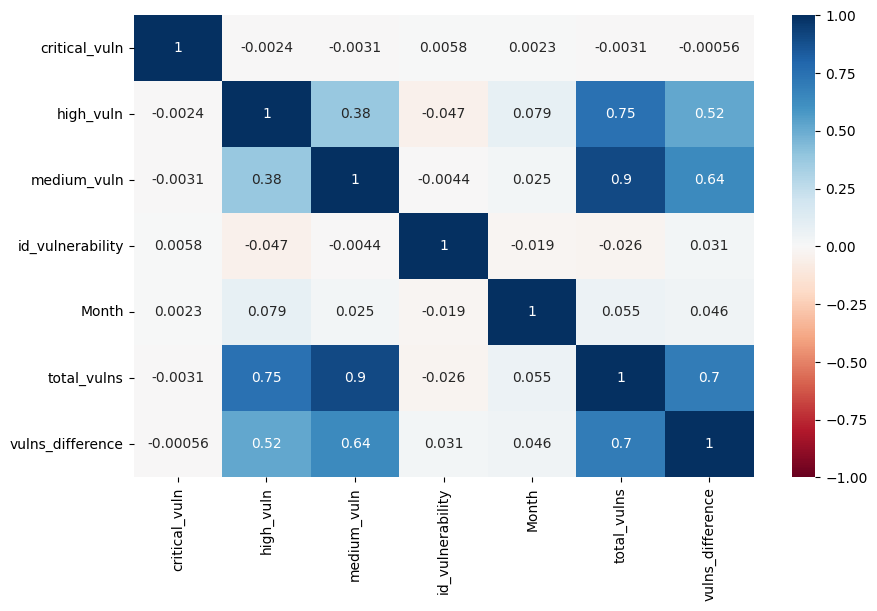

In [19]:
# matriz de correlacão com Seaborn
plt.figure(figsize = (10,6))
sns.heatmap(df_vulns.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

#### É possível ver que há uma alta correlaçao entre total_vulns e medium_vuln justamente porque a quantidade maior de vulnerabilidade vem das vulnerabilidades médias como vimos anteriormente

###Vulnerabilidades pelo tempo

In [20]:
x = df_vulns.scan_date
y = df_vulns.total_vulns
fig = px.line(df_vulns, x, y,color='id_vulnerability')
fig.show()

#### É possível ver que há uma grande correcao de vulnerabilidade na app de id 12 em junho. Enquanto que na app 176 houve um grande aumento de vulnerabilidade em outubro de forma geral, sem saber a ferramenta usada

###Vulnerabilidades x tempo x ferramenta SAST

In [21]:
x = datasetSemMissings[datasetSemMissings['tool']=='SAST'].cd_month_start
y = datasetSemMissings[datasetSemMissings['tool']=='SAST'].total_vulns
fig = px.line(datasetSemMissings[datasetSemMissings['tool']=='SAST'], x, y,color='id_vulnerability')
fig.show()

#### É possível ver que há uma grande correcao de vulnerabilidade na app de id 162 em junho. Enquanto que na app 46 houve um grande aumento de vulnerabilidade em outubro na ferramenta SAST

###Vulnerabilidades x tempo x ferramenta DAST

In [22]:
x = datasetSemMissings[datasetSemMissings['tool']=='DAST'].cd_month_start
y = datasetSemMissings[datasetSemMissings['tool']=='DAST'].total_vulns
fig = px.line(datasetSemMissings[datasetSemMissings['tool']=='DAST'], x, y,color='id_vulnerability')
fig.show()

#### É possível ver que há uma grande correcao de vulnerabilidade na app de id 92 em novembro de 2022, na ferramenta de DAST.

###Vulnerabilidades x tempo x ferramenta SCA

In [23]:
x = datasetSemMissings[datasetSemMissings['tool']=='SCA'].cd_month_start
y = datasetSemMissings[datasetSemMissings['tool']=='SCA'].total_vulns
fig = px.line(datasetSemMissings[datasetSemMissings['tool']=='SCA'], x, y,color='id_vulnerability')
fig.show()

#### Enquanto na ferramenta de SCA vemos que é dificil ocorrer um padrao de diminuicao de vulnerabilidade. Isso pode ocorrer por ser mais dificil de corrigir por serem bibliotecas vulneraveis e que nao ocorre uma aletracao no codigo, como nas demais ferramentas que detectam vulnerabilidade no codigo ou interface da aplicacao

# **Análise Gerencial**


### Apps com mais vulnerabilidades no mês atual

In [24]:
datasetSemMissings[datasetSemMissings['Month']==datasetSemMissings['Month'].max()].groupby('total_vulns').aggregate(np.sum).apply(lambda x: x.sort_values(ascending=False)).tail().drop('Month', axis=1).drop('vulns_difference', axis=1)


critical_vuln  high_vuln  medium_vuln  id_vulnerability
total_vulns                                                         
254.0                  0.0        113          141                14
279.0                  0.0         89          190                 4
281.0                  0.0        114          167                82
946.0                  0.0        696          250                11
7094.0                 0.0       4488         2606                46

### Apps com menos vulnerabilidades no mês atual

In [25]:
datasetSemMissings[datasetSemMissings['Month']==datasetSemMissings['Month'].max()].groupby('total_vulns').aggregate(np.sum).apply(lambda x: x.sort_values(ascending=False)).head().drop('Month', axis=1).drop('vulns_difference', axis=1)


critical_vuln  high_vuln  medium_vuln  id_vulnerability
total_vulns                                                         
0.0                    0.0          0            0              1546
1.0                    0.0          4            6               673
2.0                    0.0          3            7               345
3.0                    0.0          2            4               154
4.0                    0.0          0           12               140

### Apps com maior quantidade de correçoes

In [26]:
datasetSemMissings.groupby('vulns_difference').aggregate(np.sum).apply(lambda x: x.sort_values(ascending=False)).head().drop('total_vulns', axis=1).drop('Month', axis=1).drop('medium_vuln', axis=1).drop('high_vuln', axis=1).drop('critical_vuln', axis=1)


id_vulnerability
vulns_difference                  
-8233.0                         15
-6922.0                         46
-1378.0                         12
-1147.0                        162
-958.0                         125

### Apps com maior e menor quantidade de correçoes

In [27]:
datasetSemMissings.groupby('vulns_difference').aggregate(np.sum).apply(lambda x: x.sort_values(ascending=False)).tail().drop('total_vulns', axis=1).drop('Month', axis=1).drop('medium_vuln', axis=1).drop('high_vuln', axis=1).drop('critical_vuln', axis=1)


id_vulnerability
vulns_difference                  
1087.0                         122
1162.0                         162
1354.0                          12
7094.0                          46
8033.0                          15

#### Assim, é possivel saber quais equipes/aplicacoes estao seguindo a cultura de desenvolvimento seguro e como estao essas metricas por mês para que o time de seguranca possa ajudar de maneira mais eficaz essas aplicacoes